In [2]:
import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

        

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

DDPG uses four neural networks: a Q network, a deterministic policy network, a target Q network, and a target policy network.



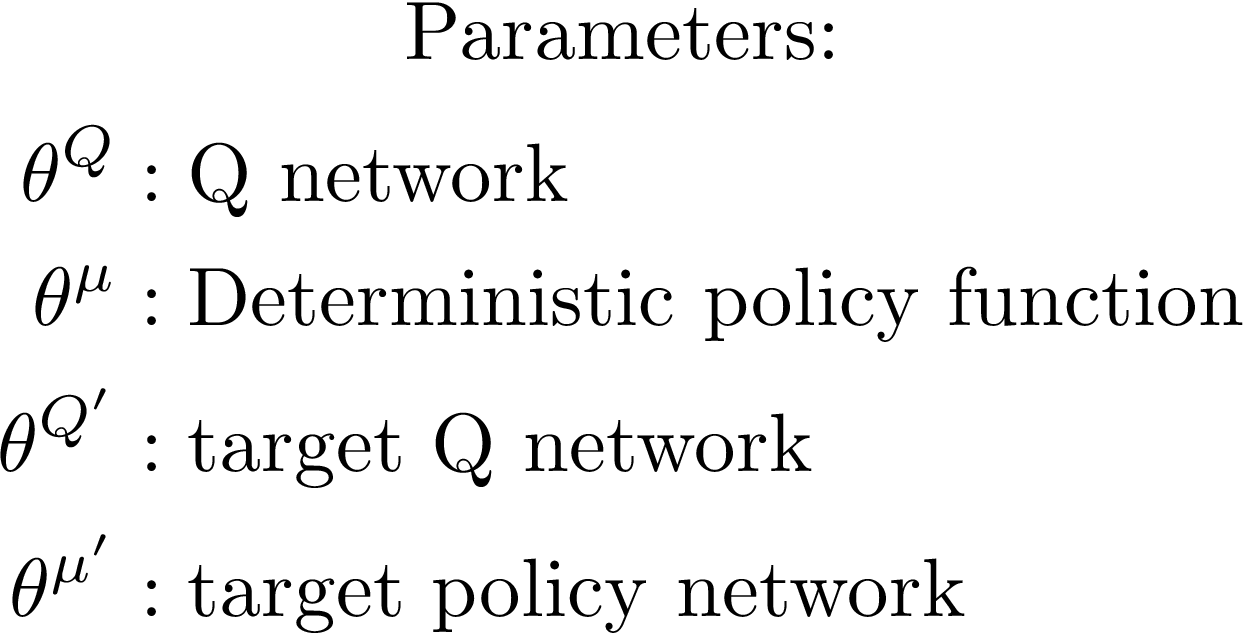



The Q network and policy network is very much like simple Advantage Actor-Critic, but in DDPG, the Actor directly maps states to actions instead of outputting the probability distribution across a discrete action space.

The target networks are time-delayed copies of their original networks that slowly track the learned networks. Using these target value networks greatly improve stability in learning. 

Let's create these networks.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

Now, let's create the DDPG agent. The agent class has two main functions: "get_action" and "update":



*   **get_action()**: This function runs a forward pass through the actor network to select a determinisitic action. In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output (Uhlenbeck & Ornstein, 1930), thereby resulting in exploration in the environment. Class OUNoise (in cell 1) implements this.


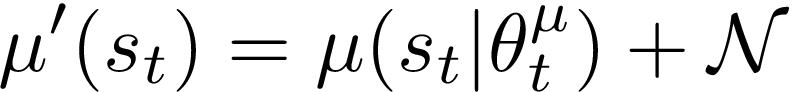



*   **update()**: This function is used for updating the actor and critic networks, and forms the core of the DDPG algorithm. The replay buffer is first sampled to get a batch of experiences of the form **<states, actions, rewards, next_states>**. 

The value network is updated using the Bellman equation, similar to Q-learning. However, in DDPG, the next-state Q values are calculated with the target value network and target policy network. Then, we minimize the mean-squared loss between the target Q value and the predicted Q value:

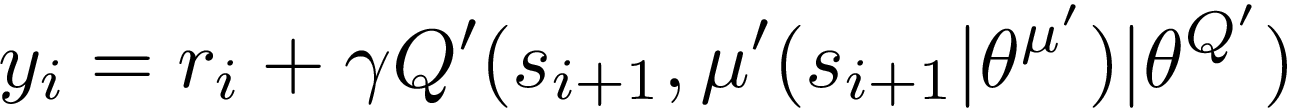

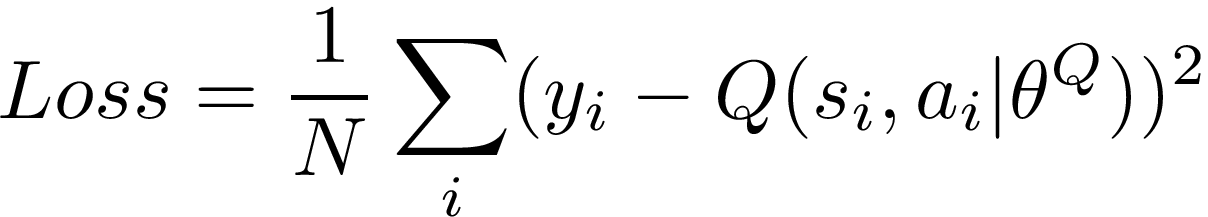

For the policy function, our objective is to maximize the expected return. To calculate the policy gradient, we take the derivative of the objective function with respect to the policy parameter. For this, we use the chain rule. 

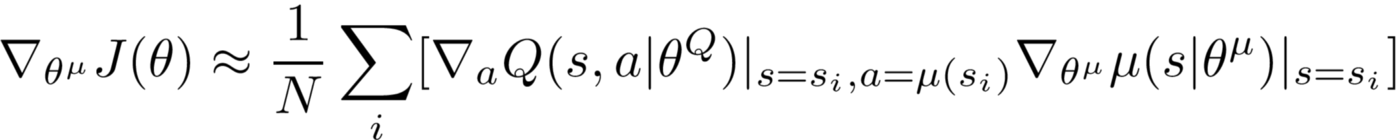

We make a copy of the target network parameters and have them slowly track those of the learned networks via “soft updates,” as illustrated below:

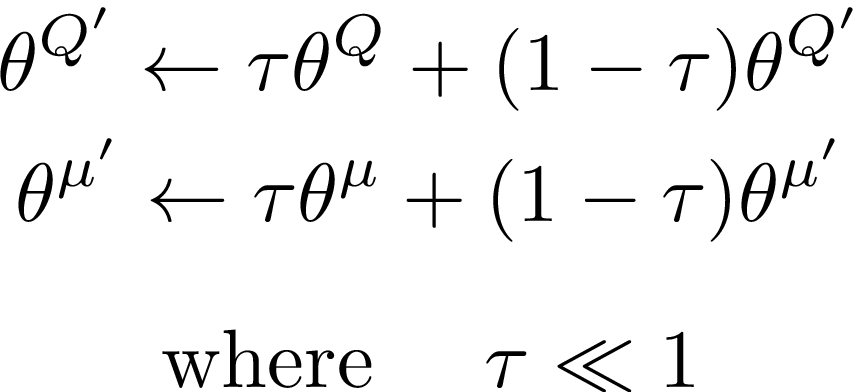






In [4]:
import torch
import torch.optim as optim
import torch.nn as nn

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Implement critic loss and update critic        
        next_y = rewards + self.gamma * self.critic_target.forward(next_states, self.actor_target.forward(next_states).detach())
        critic_loss = self.critic_criterion(self.critic.forward(states, actions), next_y)
        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # Implement actor loss and update actor
        ac_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        self.actor_optimizer.zero_grad()
        ac_loss.backward()
        self.actor_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + (1 - self.tau) * target_param.data)
            
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + (1 - self.tau) * target_param.data)

Putting it all together: DDPG in action.

The main function below runs 100 episodes of DDPG on the "Pendulum-v0" environment of OpenAI gym. This is the inverted pendulum swingup problem, a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright. 

Each episode is for a maximum of 200 timesteps. At each step, the agent chooses an action, moves to the next state and updates its parameters according to the DDPG algorithm, repeating this process till the end of the episode.

The DDPG algorithm is as follows:

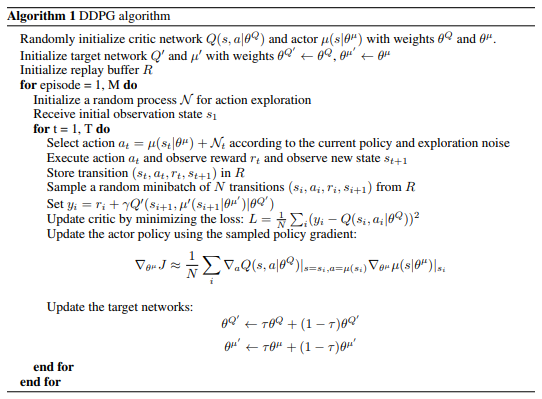

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-4-7552e94ecda3>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  states = torch.FloatTensor(states)
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474:

episode: 0, reward: -1367.65, average _reward: nan 
episode: 1, reward: -1301.28, average _reward: -1367.649356519522 
episode: 2, reward: -1499.52, average _reward: -1334.4638156223673 
episode: 3, reward: -1550.39, average _reward: -1389.4831191427122 
episode: 4, reward: -1184.65, average _reward: -1429.7104568797472 
episode: 5, reward: -1067.08, average _reward: -1380.6975318441569 
episode: 6, reward: -749.27, average _reward: -1328.4273702702656 
episode: 7, reward: -770.19, average _reward: -1245.690660270207 
episode: 8, reward: -635.35, average _reward: -1186.2528164510818 
episode: 9, reward: -493.12, average _reward: -1125.0412058811728 
episode: 10, reward: -623.36, average _reward: -1061.8488948040515 
episode: 11, reward: -388.8, average _reward: -987.4195645022362 
episode: 12, reward: -181.65, average _reward: -896.1715816214994 
episode: 13, reward: -444.49, average _reward: -764.3847650774875 
episode: 14, reward: -375.92, average _reward: -653.7944056159151 
episode

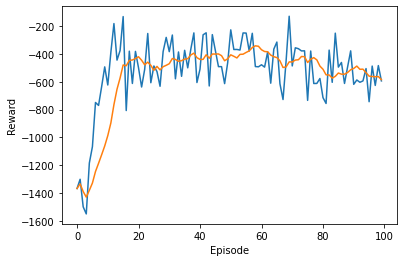

In [5]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For more info on the Pendulum environment, check out https://www.gymlibrary.dev/environments/classic_control/pendulum/
env = NormalizedEnv(gym.make("Pendulum-v1"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(100):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in range(200):
        action = agent.get_action(state)
        #Add noise to action
        
        action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward

        if done:
            sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rewards[-10:])))
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()